Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


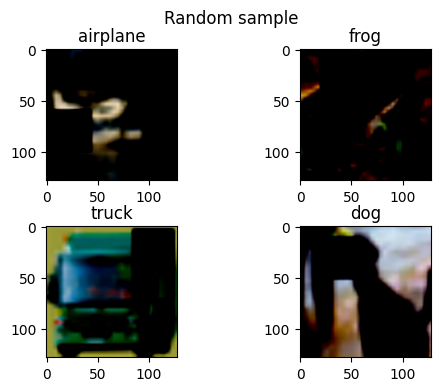

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import datasets as ds_own
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm


In [1]:
class ConvolutionalNeuralNetwork():
    
    def train_step(self, data, optimizer, criterion):
        x, y = data

        optimizer.zero_grad()

        logits = self(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        accuracy = (logits.argmax(dim=1) == y).float().mean()

        return {'loss': loss, 'accuracy': accuracy}

    
    def test_step(self, data, criterion):
        x, y = data

        logits = self(x)
        loss = criterion(logits, y)
        accuracy = (logits.argmax(dim=1) == y).float().mean()

        return {'loss': loss, 'accuracy': accuracy}
    
    def Conv2d_output_size(self, w, k, s, p):
        '''
        w - width of input image
        k - kernel size
        s - stride
        p - padding
        '''
        return (w - k + 2 * p) / s + 1

In [4]:
class CNN_3_class(nn.Module, ConvolutionalNeuralNetwork):
    def __init__(self, num_classes = 10
                    ,kernel_size=3
                    ,stride=1
                    ,padding=1
                    ,number_of_filters0=32
                    ,number_of_filters1=32
                    ,length_of_input0=32
                    ,no_neurons = 128):
        super(CNN_3_class, self).__init__()
        self.conv1 = nn.Conv2d(3, number_of_filters0, kernel_size, stride, padding)
        self.pool1 = nn.MaxPool2d(2)
        length_of_input1 = self.Conv2d_output_size(length_of_input0, kernel_size, stride, padding)/2
        self.conv2 = nn.Conv2d(number_of_filters0, number_of_filters1, kernel_size, stride, padding)
        self.pool2 = nn.MaxPool2d(2)
        length_of_input2 = self.Conv2d_output_size(length_of_input1, kernel_size, stride, padding)/2
        self.fc1 = nn.Linear(int(number_of_filters1*length_of_input2*length_of_input2), no_neurons)
        self.fc2 = nn.Linear(no_neurons, num_classes)
        # parameters
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.number_of_filters0 = number_of_filters0
        self.number_of_filters1 = number_of_filters1
        self.length_of_input0 = length_of_input0
        self.no_neurons = no_neurons
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        length_of_input1 = self.Conv2d_output_size(self.length_of_input0, self.kernel_size, self.stride, self.padding)/2
        x = self.pool2(torch.relu(self.conv2(x)))
        length_of_input2 = self.Conv2d_output_size(length_of_input1, self.kernel_size, self.stride, self.padding)/2
        x = x.view(-1, int(self.number_of_filters1*length_of_input2*length_of_input2))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:

test_loader = ds_own.val_loader
train_loader = ds_own.train_loader
basic_aug_loader = ds_own.augmentation1_loader
mixup_loader = ds_own.augmentation2_loader
cutout_loader = ds_own.augmentation3_loader

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Załaduj dane CIFAR10
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])
cifar10_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Utwórz DataLoader dla danych trenujących i testowych
trainloader = torch.utils.data.DataLoader(cifar10_train, batch_size=4, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=4, shuffle=False)

# Załaduj model AlexNet z wytrenowanymi wagami na zbiorze ImageNet
model = models.alexnet(pretrained=True)

# Zmień rozmiar ostatniej warstwy klasyfikatora na 10 wyjść
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10)

# Przenieś model na kartę graficzną, jeśli jest dostępna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Zdefiniuj funkcję straty i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Trenuj model
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch %d, loss: %.3f" % (epoch + 1, running_loss / len(trainloader)))

# Oblicz metryki na danych testowych
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Oblicz dokładność i inne metryki
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")


Files already downloaded and verified
Files already downloaded and verified


c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print("Accuracy: %.3f" % accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" % recall)
print("F1 score: %.3f" % f1)

In [18]:
learning_rate = 0.001
# batch_size = 64 TEGO NIE UZYWAMY A JESLI CHCEMY TO W LOADERZE TRZEBA DODAC
num_epochs = 2
optimizer = optim.Adam
activation_func = nn.ReLU()
# dropout_rate = 0.1
criterion = nn.CrossEntropyLoss()

# Create model, criterion, and optimizer
model = CNN_3_class(num_classes = 10,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                    number_of_filters0=64,
                    number_of_filters1=64,
                    length_of_input0=32,
                    no_neurons = 16)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
epochs = num_epochs
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_losses = []
    train_accuracies = []
    for data in tqdm(train_loader):
        results = model.train_step(data, optimizer, criterion)
        train_losses.append(results['loss'].item())
        train_accuracies.append(results['accuracy'].item())

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    print(f'Train loss: {avg_train_loss:.4f}, Train accuracy: {avg_train_accuracy:.4f}')

    # Test the model
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            results = model.test_step(data, criterion)
            val_losses.append(results['loss'].item())
            val_accuracies.append(results['accuracy'].item())

    # Calculate average test loss and accuracy for the epoch
    avg_validation_loss = sum(val_losses) / len(val_losses)
    avg_validation_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f'Validation loss: {avg_validation_loss:.4f}, Validation accuracy: {avg_validation_accuracy:.4f}')


Epoch 1/2


  2%|▏         | 25/1250 [00:02<02:20,  8.73it/s]


KeyboardInterrupt: 

### CNN from article about weighted random search

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import datasets
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm

class MyCNN(nn.Module, ConvolutionalNeuralNetwork):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=736, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=736, out_channels=508, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=508, out_channels=664, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=664, out_channels=916, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(in_channels=916, out_channels=186, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=186, out_channels=352, kernel_size=3, padding=1)
        self.linear = nn.Linear(in_features=22528, out_features=1229)
        self.output = nn.Linear(in_features=1229, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = self.maxpool2(x)
        x = self.conv5(x)
        x = nn.functional.relu(x)
        x = self.conv6(x)
        x = nn.functional.relu(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = nn.functional.relu(x)
        x = self.output(x)
        return x

# another aproach to alexnet

In [4]:
import torch.nn as nn
import torchvision.models as models

class PretrainedAlexNet(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super().__init__()

        self.model = models.alexnet(pretrained=pretrained)
        
        # Modify the last fully connected layer to output num_classes
        self.model.classifier[-1] = nn.Linear(4096, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    


In [5]:
from datasets import CifarDataset

In [7]:
# Path to training and validation directories
TRAIN_DIR = 'Cifar10\\train'
VAL_DIR = 'Cifar10\\val'

# Path to dataframe with labels for training and validation data
TRAIN_LABELS = 'Cifar10\\trainLabels.csv'
VAL_LABELS = 'Cifar10\\valLabels.csv'

# List of class names
CLASS_NAMES = ['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship', 'cat', 'dog',
 'airplane']

# Dictionary for encoding class names
CLASS_DICT = {CLASS_NAMES[i]: i for i in range(len(CLASS_NAMES))}

# Size in pixels of single image
IMG_SIZE=32

# import transforms
import torchvision.transforms as transforms
transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


# Create pyTorch Dataset instances of training and validation data
cifar_train = CifarDataset(root_dir = TRAIN_DIR, labels=TRAIN_LABELS, 
                           transform=transformer, class_dict=CLASS_DICT)
cifar_val = CifarDataset(root_dir = VAL_DIR, labels=VAL_LABELS, 
                         transform=transformer, class_dict=CLASS_DICT)

train_loader = DataLoader(cifar_train, batch_size=32, shuffle=True)
test_loader = DataLoader(cifar_val, batch_size=32, shuffle=False)

In [8]:
# transform my loader with transforms


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 10

# Prepare CIFAR10 dataset and dataloaders
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
# train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
# test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# test_loader = ds_own.val_loader
# train_loader = ds_own.train_loader

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
model = PretrainedAlexNet(num_classes=num_classes).to(device)


c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# print('1')
a = 0
# Train the model


from tqdm import tqdm

for epoch in range(num_epochs):
    running_loss = 0.0
    a = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()
        try:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        except:
            a += 1
            continue
    print('Epoch {} loss: {:.3f}'.format(epoch+1, running_loss/len(train_loader)))
    print('Finished Training, {} errors'.format(a))



 52%|█████▏    | 651/1250 [07:19<07:05,  1.41it/s]

In [ ]:

# Evaluate the model
model.eval()
with torch.no_grad():
    total_correct = 0
    total_samples = 0
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()
    print('Test accuracy: {:.2f}%'.format(100 * total_correct / total_samples))


In [61]:
inputs.shape

torch.Size([32, 3, 32, 32])

In [29]:
learning_rate = 0.001
# batch_size = 64 TEGO NIE UZYWAMY A JESLI CHCEMY TO W LOADERZE TRZEBA DODAC
num_epochs = 2
optimizer = optim.Adam
activation_func = nn.ReLU()
# dropout_rate = 0.1
criterion = nn.CrossEntropyLoss()

# Create model, criterion, and optimizer
# model = CNN_3_class(num_classes = 10,
#                     kernel_size=3,
#                     stride=1,
#                     padding=1,
#                     number_of_filters0=64,
#                     number_of_filters1=64,
#                     length_of_input0=32,
#                     no_neurons = 16)

model = PretrainedAlexNet(num_classes=10, pretrained=True)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
epochs = num_epochs
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_losses = []
    train_accuracies = []
    for data in tqdm(train_loader):
        results = model.train_step(data, optimizer, criterion)
        train_losses.append(results['loss'].item())
        train_accuracies.append(results['accuracy'].item())

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
    print(f'Train loss: {avg_train_loss:.4f}, Train accuracy: {avg_train_accuracy:.4f}')

    # Test the model
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            results = model.test_step(data, criterion)
            val_losses.append(results['loss'].item())
            val_accuracies.append(results['accuracy'].item())

    # Calculate average test loss and accuracy for the epoch
    avg_validation_loss = sum(val_losses) / len(val_losses)
    avg_validation_accuracy = sum(val_accuracies) / len(val_accuracies)
    print(f'Validation loss: {avg_validation_loss:.4f}, Validation accuracy: {avg_validation_accuracy:.4f}')

c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/2


  0%|          | 0/1250 [00:01<?, ?it/s]


RuntimeError: Given input size: (256x1x1). Calculated output size: (256x0x0). Output size is too small

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import pandas as pd
from tqdm import tqdm
import numpy as np

# Definicja transformacji danych
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Załadowanie danych
train_dir = 'Cifar10/train'
val_dir = 'Cifar10/test'
train_labels_path = 'Cifar10/trainLabels.csv'
val_labels_path = 'Cifar10/valLabels.csv'

class MyDataset(Dataset):
    def __init__(self, data_dir, labels_file, transform=None):
        self.data = datasets.ImageFolder(root=data_dir, transform=transform)
        self.labels = pd.read_csv(labels_file)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img, _ = self.data[idx]
        label = self.labels.iloc[idx]['label']
        return img, label
    
train_dataset = MyDataset(train_dir, train_labels_path, transform=train_transforms)
val_dataset = MyDataset(val_dir, val_labels_path, transform=val_transforms)


FileNotFoundError: Couldn't find any class folder in Cifar10/train.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
import os

# Define the dataset class
class CifarDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.df.iloc[idx, 1]
        return image, label

# Define the transforms for the data
transform_train = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the data loaders for training and validation
train_dataset = CifarDataset(train_csv_path, train_dir, transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = CifarDataset(val_csv_path, val_dir, transform_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Download and load the pretrained AlexNet model
model = torchvision.models.alexnet(pretrained=True)

# Modify the model for our classification task
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    print('Epoch {}: Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, epoch_loss, epoch_acc))

# Test the accuracy of the trained model on the validation set
model.eval()
running_corrects = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to


c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U4')) -> None

In [10]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class Cifar10Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.df.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.df.iloc[idx, 1]

        return image, label

train_csv_path = 'Cifar10/trainLabels.csv'
val_csv_path = 'Cifar10/valLabels.csv'

train_dir = 'Cifar10/train'
val_dir = 'Cifar10/val'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = Cifar10Dataset(csv_file=train_csv_path, root_dir=train_dir, transform=transform)
val_dataset = Cifar10Dataset(csv_file=val_csv_path, root_dir=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Rest of the code remains the same


# Definicja modelu
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # 10 to liczba klas

# Definicja funkcji straty i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Przesyłanie modelu na urządzenie GPU, jeśli jest dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Trening modelu
num_epochs = 10

best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_running_loss += loss.item() * inputs.size(0)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
        .format(epoch+1, num_epochs, epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc))

    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), 'best_model.pt')


c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U4')) -> None

In [12]:
alexnet = models.alexnet(pretrained=True)

c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mikol\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Now using the AlexNet
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

#Model description
AlexNet_model.eval()

In [17]:
from datasets import CifarDataset

In [ ]:
data = CifarDataset